In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/852k-used-car-listings/tc20171021.csv
/kaggle/input/852k-used-car-listings/true_car_listings.csv


In [85]:
import pandas as pd
import numpy as np
import scipy as spy
import copy
import math
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn import linear_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [87]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [88]:
!ls /kaggle/input/852k-used-car-listings


tc20171021.csv	true_car_listings.csv


In [89]:
data = pd.read_csv(
    "/kaggle/input/852k-used-car-listings/tc20171021.csv",
    on_bad_lines='skip',
    low_memory=False
)


In [52]:
# Preview the dataset
# View the first 5, last 5 and random 10 rows
print('First five rows', '--'*55)
display(data.head())

print('Last five rows', '--'*55)
display(data.tail())

print('Random ten rows', '--'*55)
np.random.seed(1)
display(data.sample(n=10))

First five rows --------------------------------------------------------------------------------------------------------------


,Id,Price,Year,Mileage,City,State,Vin,Make,Model
0,1,16472,2015,18681,Jefferson City,MO,KL4CJBSBXFB267643,Buick,EncoreConvenience
1,2,15749,2015,27592,Highland,IN,KL4CJASB5FB245057,Buick,EncoreFWD
2,3,16998,2015,13650,Boone,NC,KL4CJCSB0FB264921,Buick,EncoreLeather
3,4,15777,2015,25195,New Orleans,LA,KL4CJASB4FB217542,Buick,EncoreFWD
4,5,16784,2015,22800,Las Vegas,NV,KL4CJBSB3FB166881,Buick,EncoreConvenience


Last five rows --------------------------------------------------------------------------------------------------------------


,Id,Price,Year,Mileage,City,State,Vin,Make,Model
1216245,1233038,79900,2017,25,East Hanover,NJ,YV4BC0ZX0H1128239,Volvo,XC90T8
1216246,1233039,80895,2017,10,Corte Madera,CA,YV4BC0ZX0H1124188,Volvo,XC90T8
1216247,1233040,68755,2018,2500,Englewood,NJ,YV4A22PL4J1212676,Volvo,XC90T6
1216248,1233041,72260,2017,3201,Englewood,NJ,YV4A22PL3H1186162,Volvo,XC90T6
1216249,1233042,60240,2017,8342,San Leandro,CA,YV4A22NLXH1006162,Volvo,V90


Random ten rows --------------------------------------------------------------------------------------------------------------


,Id,Price,Year,Mileage,City,State,Vin,Make,Model
133425,133426,13600,2015,16421,San Jose,CA,1G1PD5SB2F7105582,Chevrolet,Cruze1LT
372896,378263,13995,2011,93745,Yonkers,NY,5FNRL5H68BB035118,Honda,Odyssey5dr
1177634,1194263,33000,2015,45937,Ballwin,MO,JTEBU5JR0F5232211,Toyota,4RunnerSR5
204824,204825,5000,2006,172148,Murrysville,PA,JH4CL959X6C035487,Acura,TSXManual
887684,893051,35998,2013,43889,Colfax,CA,1C4HJWFG4DL694901,Jeep,Wrangler
844228,849595,34990,2012,37179,Edgewater Park,NJ,SAJWA2GE2CMV30506,Jaguar,XJ4dr
974685,980053,17490,2011,81929,Nashville,TN,WDDHF5GB0BA326180,Mercedes-Benz,E-Class4dr
50282,50283,15691,2012,74049,Louisville,KY,2FMDK3K9XCBA79149,Ford,Edge4dr
916685,922052,28870,2017,5,San Jose,CA,KNAGT4LE2H5016829,Kia,OptimaPremium
862484,867851,14495,2015,33038,CARLSBAD,CA,1C4NJCEA8FD361189,Jeep,CompassLatitude


**Observations:**
* The **S.No.** is simply a row identifier which can be removed later.
* The **Name** is long string comprising the Brand, Model and addition specification. These can be split to further analyse by make and model.
* The **Location** is a geographical location. We can possibly create a heat map of car make by location.
* The **Fuel_Type**, **Transmission** and **Owner_Type** are categorical variable which can be possibly be onehot encoded.
* **Mileage** is a string leading with number and unit. This shall be split into the mileage number and mileage unit. Further analysis will determine if the mileage number to be converted based on the units.
* **Engine** and **Power** both are strings leading with number and unit. This shall be split and numerical portion will be used in analysis.
* **Seats** is a discrete numerical variable.
* **New_Price** has many missing values. Where it contains a value the currency term shall be removed by splitting.
* **Price** has missing values

In [53]:
data.columns = [col.lower() for col in data.columns]

In [54]:
data.head(1)

,id,price,year,mileage,city,state,vin,make,model
0,1,16472,2015,18681,Jefferson City,MO,KL4CJBSBXFB267643,Buick,EncoreConvenience


In [55]:
# Display list of variables in dataset
variable_list = data.columns.tolist()
print(variable_list)

['id', 'price', 'year', 'mileage', 'city', 'state', 'vin', 'make', 'model']


In [56]:
shape = data.shape
n_rows = shape[0]
n_cols = shape[1]
print(f"The Dataframe consists of '{n_rows}' rows and '{n_cols}' columns")

The Dataframe consists of '1216250' rows and '9' columns


In [57]:
# Get info of the dataframe columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216250 entries, 0 to 1216249
Data columns (total 9 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   id       1216250 non-null  int64 
 1   price    1216250 non-null  int64 
 2   year     1216250 non-null  int64 
 3   mileage  1216250 non-null  int64 
 4   city     1216250 non-null  object
 5   state    1216250 non-null  object
 6   vin      1216250 non-null  object
 7   make     1216250 non-null  object
 8   model    1216250 non-null  object
dtypes: int64(4), object(5)
memory usage: 83.5+ MB


In [58]:
# Panda Object Variable states function

def pandas_object_states(data):
    """
    This function checks if the variable type is pandas Object and
    displays the states and counts of each
    """
    # Loop through all variables
    for var in data.columns:
        # Check for pandas Object type
        if data[var].dtypes == "object":
            print('Unique values in', var, 'are :')
            print(data[var].value_counts().sort_index())
            print('--'*55)

In [59]:
# Check the states of all pandas Object variables
pandas_object_states(data)

Unique values in city are :
city
AKRON           12
ALEXANDRIA      99
AURORA          89
AUSTIN         595
AVON             6
              ... 
kansas city    101
marietta        52
phoenix         82
salt lake       33
victorville    128
Name: count, Length: 2599, dtype: int64
--------------------------------------------------------------------------------------------------------------
Unique values in state are :
state
AK      2241
AL     18493
AR      9449
AZ     32682
Az        91
CA    114615
CO     32721
CT     14798
Ca        44
DC        29
DE      3693
FL    106290
Fl      1065
GA     55259
Ga       197
HI      3716
IA      6739
ID      4944
IL     54794
IN     23315
KS     10974
KY     19811
LA     11463
MA     26016
MD     25147
ME      2596
MI     15099
MN     15768
MO     23138
MS      8538
MT      2588
Md       239
NC     52584
ND      1827
NE      7126
NH      8195
NJ     38216
NM      6972
NV     10284
NY     37729
OH     33886
OK     14727
OR     14612
Oh        95


In [60]:
def missing_val_chk(data):
    """
    This function to checks for missing values 
    and generates a summary.
    """
    if data.isnull().sum().any() == True:
        # Number of missing in each column
        missing_vals = pd.DataFrame(data.isnull().sum().sort_values(
            ascending=False)).rename(columns={0: '# missing'})

        # Create a percentage missing
        missing_vals['percent'] = ((missing_vals['# missing'] / len(data)) *
                                   100).round(decimals=3)

        # Remove rows with 0
        missing_vals = missing_vals[missing_vals['# missing'] != 0].dropna()

        # display missing value dataframe
        print("The missing values summary")
        display(missing_vals)
    else:
        print("There are NO missing values in the dataset")

In [61]:
#Applying the missing value summary function
missing_val_chk(data)

There are NO missing values in the dataset


In [62]:
# Five point summary of all numerical type variables in the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1216250.0,613281.414060,354657.101145,1.0,308112.25,613491.5,917553.75,1233042.0
price,1216250.0,20968.870680,13159.401788,1500.0,12994.00,17995.0,26414.00,499500.0
year,1216250.0,2013.307161,3.441842,1997.0,2012.00,2014.0,2016.00,2018.0
mileage,1216250.0,52908.102305,81927.748757,5.0,23962.00,40534.0,72725.00,77587763.0


In [63]:
data.describe(include=['object']).T

,count,unique,top,freq
city,1216250,2599,Houston,20315
state,1216250,59,TX,139335
vin,1216250,1216250,KL4CJBSBXFB267643,1
make,1216250,58,Ford,161999
model,1216250,3105,Silverado,36174


In [64]:
# Extract the index values and convert to Pandas Series for comparison
idx = pd.Series(data.index.values, name="index")

# Extract the first column safely (whatever its name is)
first_col = data.iloc[:, 0]

# Display both to verify
print("Index values:\n", idx.head())
print("\nFirst column:\n", first_col.head())


Index values:
 0    0
1    1
2    2
3    3
4    4
Name: index, dtype: int64

First column:
 0    1
1    2
2    3
3    4
4    5
Name: id, dtype: int64


In [65]:
first_col.equals(idx)

False

In [66]:
data.drop(columns=[col for col in ['s.no.', 'Id'] if col in data.columns], inplace=True)


In [67]:
data = data.rename(columns={'mileage_no': 'mileage'})

In [68]:
if data.mileage.dtypes != np.number:
    # This will convert all numeric strings to float.
    # If a value is non numeric it will set to NaN
    data['mileage'] = pd.to_numeric(data.mileage, errors='coerce')

In [69]:
# Check if 'engine' column exists before splitting
if 'engine' in data.columns:
    data[['engine_disp', 'eng_disp_unit']] = data['engine'].str.split(' ', n=1, expand=True)
else:
    print("⚠️ No 'engine' column found in this dataset. Skipping engine split.")


⚠️ No 'engine' column found in this dataset. Skipping engine split.


In [70]:
data.head(1)

,id,price,year,mileage,city,state,vin,make,model
0,1,16472,2015,18681,Jefferson City,MO,KL4CJBSBXFB267643,Buick,EncoreConvenience


In [71]:
if 'name' in data.columns:
    data = data.drop(columns='name')


In [72]:
print(data.columns)

Index(['id', 'price', 'year', 'mileage', 'city', 'state', 'vin', 'make',
       'model'],
      dtype='object')


In [73]:
data['car_make'].value_counts() if 'car_make' in data.columns else None


In [74]:
# Separating Independent and Dependent variables

# Independent variables
X = data.drop(['price'], axis=1)

# Dependent variable
y = data[['price']]


In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ----------------------------
# Load training and test datasets
# ----------------------------
train_data =data
test_data = pd.read_csv("/kaggle/input/852k-used-car-listings/true_car_listings.csv",
                        on_bad_lines='skip')

# Standardize column names
train_data.columns = train_data.columns.str.lower().str.strip()
test_data.columns = test_data.columns.str.lower().str.strip()

# ----------------------------
# Select important columns
# ----------------------------
important_cols = ['price', 'year', 'mileage', 'state', 'city', 'make', 'model']

X_train_selected = train_data[important_cols].copy()
X_test_selected = test_data[important_cols].copy()

# ----------------------------
# Encode categorical columns with OrdinalEncoder
# ----------------------------
categorical_cols = ['state', 'city', 'make', 'model']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_selected[categorical_cols] = encoder.fit_transform(
    X_train_selected[categorical_cols].astype(str)
)
X_test_selected[categorical_cols] = encoder.transform(
    X_test_selected[categorical_cols].astype(str)
)

# ----------------------------
# Prepare target
# ----------------------------
Y_train = pd.to_numeric(X_train_selected['price'], errors='coerce')
Y_test = pd.to_numeric(X_test_selected['price'], errors='coerce')

# Drop rows with missing targets
train_valid_idx = ~np.isnan(Y_train)
X_train_final = X_train_selected.loc[train_valid_idx].drop(columns='price')
Y_train_final = Y_train[train_valid_idx]

test_valid_idx = ~np.isnan(Y_test)
X_test_final = X_test_selected.loc[test_valid_idx].drop(columns='price')
Y_test_final = Y_test[test_valid_idx]

print("Training shape:", X_train_final.shape)
print("Testing shape:", X_test_final.shape)

# ----------------------------
# Fit Linear Regression
# ----------------------------
model = LinearRegression(fit_intercept=True)
model.fit(X_train_final, Y_train_final)

# ----------------------------
# Evaluate on test data
# ----------------------------
Y_pred_test = model.predict(X_test_final)

r2 = r2_score(Y_test_final, Y_pred_test)
mse = mean_squared_error(Y_test_final, Y_pred_test)
rmse = np.sqrt(mse)

print("\nTest Performance:")
print("R² Score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# ----------------------------
# Feature importance
# ----------------------------
coef_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop Features by Influence:")
print(coef_df)


Training shape: (1216250, 6)
Testing shape: (852122, 6)

Test Performance:
R² Score: 0.17673770176573578
Mean Squared Error: 152185385.74038622
Root Mean Squared Error: 12336.344099464242

Top Features by Influence:
   Feature  Coefficient
0     year  1463.567060
4     make   -65.460808
2    state    20.247143
5    model     1.254896
3     city    -0.299870
1  mileage    -0.010546


In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler




# ----------------------------
# Load training and test datasets
# ----------------------------
train_data = data
test_data = pd.read_csv("/kaggle/input/852k-used-car-listings/true_car_listings.csv",
                        on_bad_lines='skip')

# Standardize column names
train_data.columns = train_data.columns.str.lower().str.strip()
test_data.columns = test_data.columns.str.lower().str.strip()

# ----------------------------
# Select important columns
# ----------------------------
important_cols = ['price', 'year', 'mileage', 'state', 'city', 'make', 'model']

X_train_selected = train_data[important_cols].copy()
X_test_selected = test_data[important_cols].copy()

# ----------------------------
# Encode categorical columns with OrdinalEncoder
# ----------------------------
categorical_cols = ['state', 'city', 'make', 'model']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_selected[categorical_cols] = encoder.fit_transform(
    X_train_selected[categorical_cols].astype(str)
)
X_test_selected[categorical_cols] = encoder.transform(
    X_test_selected[categorical_cols].astype(str)
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# ----------------------------
# Prepare target
# ----------------------------
Y_train = pd.to_numeric(X_train_selected['price'], errors='coerce')
Y_test = pd.to_numeric(X_test_selected['price'], errors='coerce')

# Drop rows with missing targets
train_valid_idx = ~np.isnan(Y_train)
X_train_final = X_train_selected.loc[train_valid_idx].drop(columns='price')
Y_train_final = Y_train[train_valid_idx]

test_valid_idx = ~np.isnan(Y_test)
X_test_final = X_test_selected.loc[test_valid_idx].drop(columns='price')
Y_test_final = Y_test[test_valid_idx]

print("Training shape:", X_train_final.shape)
print("Testing shape:", X_test_final.shape)

# ----------------------------
# Helper: Adjusted R² function
# ----------------------------
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# ----------------------------
# Define models
# ----------------------------
models = {
    "Linear Regression": LinearRegression(fit_intercept=True),
    "Lasso Regression": Lasso(alpha=10, max_iter=10000),
    "Ridge Regression": Ridge(alpha=50)
}

results = []

# ----------------------------
# Train, predict, and evaluate each model
# ----------------------------
for name, model in models.items():
    model.fit(X_train_final, Y_train_final)
    Y_pred_test = model.predict(X_test_final)

    r2 = r2_score(Y_test_final, Y_pred_test)
    adj_r2 = adjusted_r2(r2, n=len(Y_test_final), k=X_test_final.shape[1])
    mse = mean_squared_error(Y_test_final, Y_pred_test)
    rmse = np.sqrt(mse)

    results.append({
        'Model': name,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'MSE': mse,
        'RMSE': rmse
    })

# ----------------------------
# Show metrics
# ----------------------------
print("\n=== Model Performance Comparison ===")
metrics_df = pd.DataFrame(results)
print(metrics_df)

# ----------------------------
# Feature importance (for Linear Regression)
# ----------------------------
coef_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': models["Linear Regression"].coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop Features by Influence (Linear Regression):")
print(coef_df)


Training shape: (1216250, 6)
Testing shape: (852122, 6)

=== Model Performance Comparison ===
               Model        R²  Adjusted R²           MSE          RMSE
0  Linear Regression  0.176738     0.176732  1.521854e+08  12336.344099
1   Lasso Regression  0.176743     0.176738  1.521843e+08  12336.301659
2   Ridge Regression  0.176738     0.176732  1.521854e+08  12336.343849

Top Features by Influence (Linear Regression):
   Feature  Coefficient
0     year  1463.567060
4     make   -65.460808
2    state    20.247143
5    model     1.254896
3     city    -0.299870
1  mileage    -0.010546


Training shape: (1216250, 6)
Testing shape: (852122, 6)
Best Lasso alpha: 100.0
Best Ridge alpha: 100.0


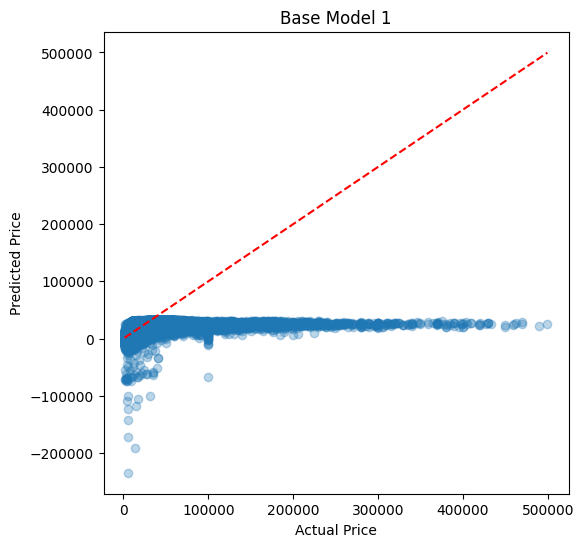

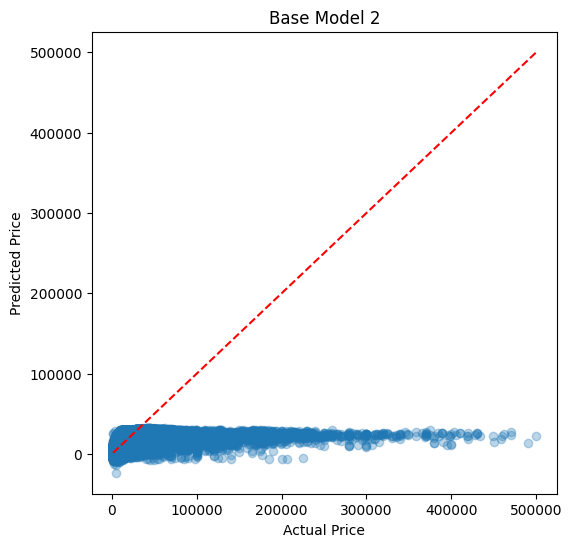

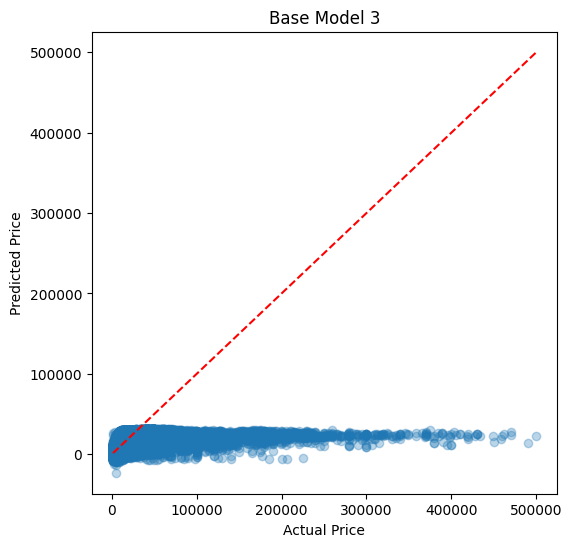

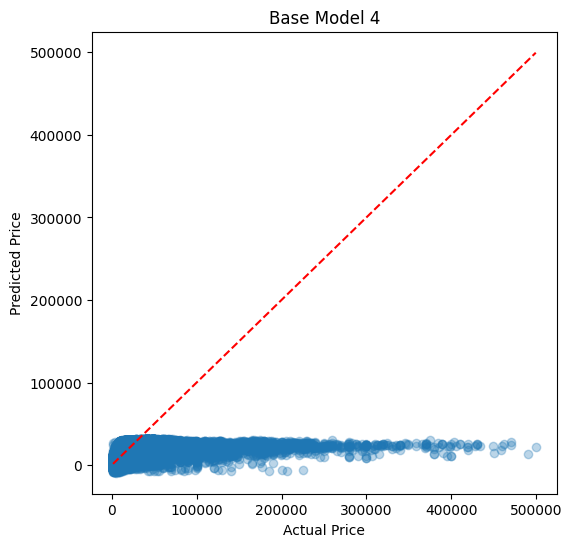

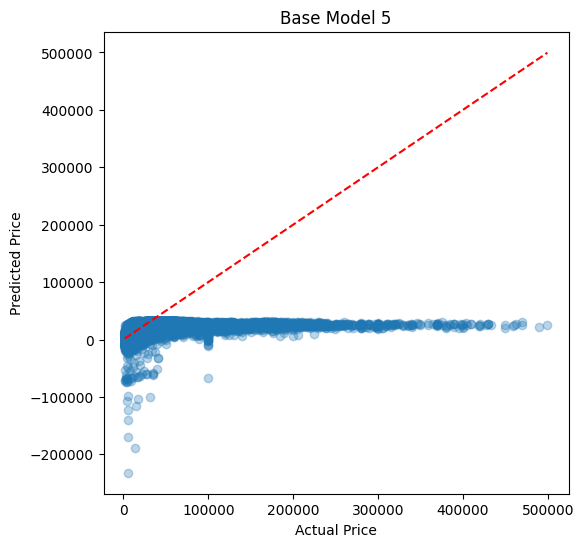

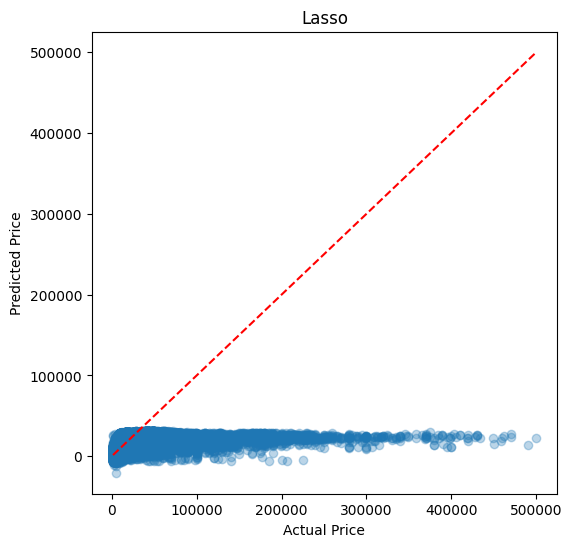

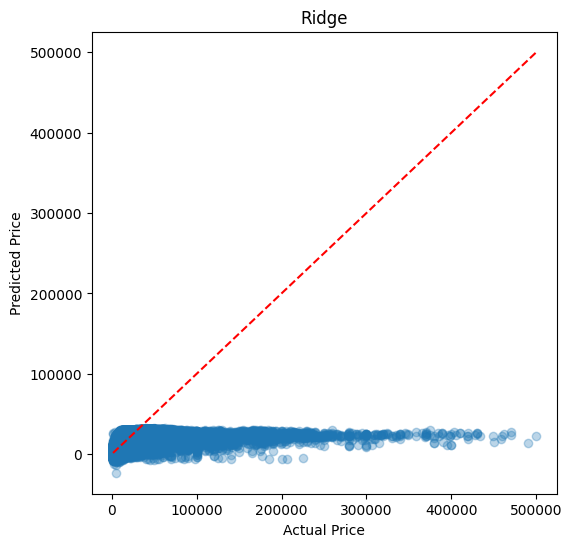


Simple Average Ensemble - R2: 0.1926, Adj R2: 0.1926, RMSE: 12216.85


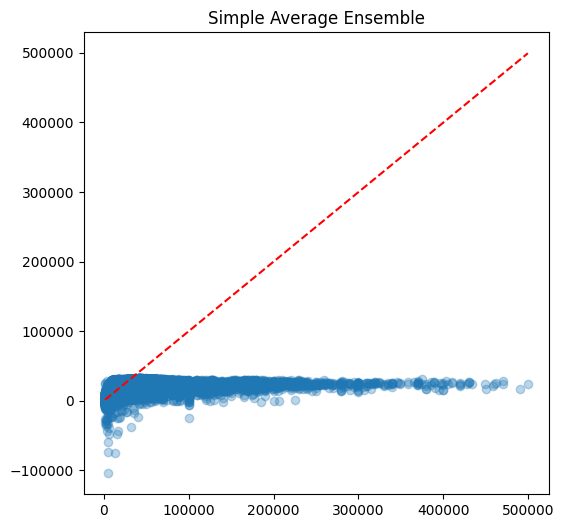


Weighted Average Ensemble - R2: 0.1929, Adj R2: 0.1929, RMSE: 12214.82


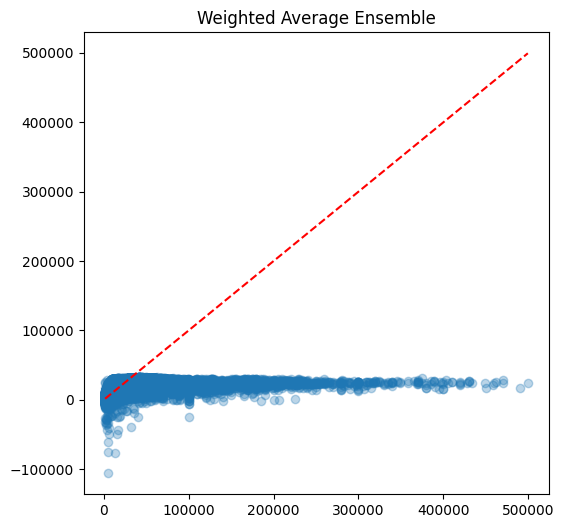

Learned stacking weights (a, b): [-28378.23529245  28382.06551568]
Stacking intercept: -59344.91571188683

Stacking Ensemble (learned a & b) - R2: 0.2010, Adj R2: 0.2010, RMSE: 12153.29


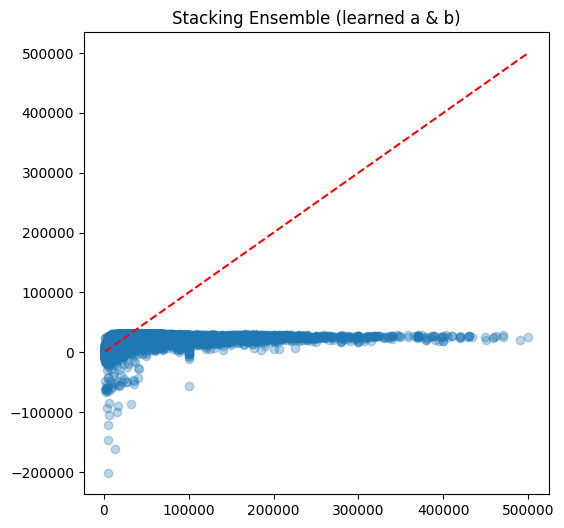


All Base & Baseline Models Metrics:
          Model        R2    Adj R2          RMSE
0  Base Model 1  0.203107  0.203101  12137.168470
1  Base Model 2  0.176830  0.176824  12335.655279
2  Base Model 3  0.176596  0.176591  12337.402157
3  Base Model 4  0.173045  0.173039  12363.983581
4  Base Model 5  0.203229  0.203223  12136.239373
5         Lasso  0.176012  0.176006  12341.779921
6         Ridge  0.176738  0.176732  12336.341122


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

# ----------------------------
# Load datasets
# ----------------------------
train_data = data
test_data = pd.read_csv("/kaggle/input/852k-used-car-listings/true_car_listings.csv",
                        on_bad_lines='skip')

# Standardize column names
train_data.columns = train_data.columns.str.lower().str.strip()
test_data.columns = test_data.columns.str.lower().str.strip()

# ----------------------------
# Select important columns
# ----------------------------
important_cols = ['price', 'year', 'mileage', 'state', 'city', 'make', 'model']
X_train_selected = train_data[important_cols].copy()
X_test_selected = test_data[important_cols].copy()

# ----------------------------
# Encode categorical columns
# ----------------------------
categorical_cols = ['state', 'city', 'make', 'model']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_selected[categorical_cols] = encoder.fit_transform(
    X_train_selected[categorical_cols].astype(str)
)
X_test_selected[categorical_cols] = encoder.transform(
    X_test_selected[categorical_cols].astype(str)
)

# ----------------------------
# Prepare target
# ----------------------------
Y_train = pd.to_numeric(X_train_selected['price'], errors='coerce')
Y_test = pd.to_numeric(X_test_selected['price'], errors='coerce')

# Drop rows with missing targets
train_valid_idx = ~np.isnan(Y_train)
X_train_final = X_train_selected.loc[train_valid_idx].drop(columns='price')
Y_train_final = Y_train[train_valid_idx]

test_valid_idx = ~np.isnan(Y_test)
X_test_final = X_test_selected.loc[test_valid_idx].drop(columns='price')
Y_test_final = Y_test[test_valid_idx]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print("Training shape:", X_train_scaled.shape)
print("Testing shape:", X_test_scaled.shape)

# ----------------------------
# Adjusted R² function
# ----------------------------
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# ----------------------------
# Alpha tuning for Lasso and Ridge using GridSearchCV
# ----------------------------
alphas = np.logspace(-2, 2, 20)

# Lasso
lasso = Lasso(max_iter=10000)
grid_lasso = GridSearchCV(lasso, param_grid={'alpha': alphas}, scoring='r2', cv=5)
grid_lasso.fit(X_train_scaled, Y_train_final)
best_alpha_lasso = grid_lasso.best_params_['alpha']
print("Best Lasso alpha:", best_alpha_lasso)

# Ridge
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid={'alpha': alphas}, scoring='r2', cv=5)
grid_ridge.fit(X_train_scaled, Y_train_final)
best_alpha_ridge = grid_ridge.best_params_['alpha']
print("Best Ridge alpha:", best_alpha_ridge)

# ----------------------------
# 5 Base Linear Regression models using bootstrap samples
# ----------------------------
base_preds = []
base_metrics = []

for i in range(5):
    # Bootstrap sample
    X_sample, Y_sample = resample(X_train_scaled, Y_train_final, n_samples=len(Y_train_final), random_state=i)
    model = LinearRegression()
    model.fit(X_sample, Y_sample)
    pred = model.predict(X_test_scaled)
    base_preds.append(pred)
    
    # Evaluate
    r2 = r2_score(Y_test_final, pred)
    adj = adjusted_r2(r2, n=len(Y_test_final), k=X_test_scaled.shape[1])
    mse = mean_squared_error(Y_test_final, pred)
    rmse = np.sqrt(mse)
    base_metrics.append({'Model': f'Base Model {i+1}', 'R2': r2, 'Adj R2': adj, 'RMSE': rmse})
    
    # Plot
    plt.figure(figsize=(6,6))
    plt.scatter(Y_test_final, pred, alpha=0.3)
    plt.plot([Y_test_final.min(), Y_test_final.max()],
             [Y_test_final.min(), Y_test_final.max()], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Base Model {i+1}")
    plt.show()

# ----------------------------
# Evaluate Lasso and Ridge (baseline)
# ----------------------------
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
ridge_model = Ridge(alpha=best_alpha_ridge)

lasso_model.fit(X_train_scaled, Y_train_final)
ridge_model.fit(X_train_scaled, Y_train_final)

lasso_pred = lasso_model.predict(X_test_scaled)
ridge_pred = ridge_model.predict(X_test_scaled)

baseline_metrics = []

for name, pred in zip(["Lasso", "Ridge"], [lasso_pred, ridge_pred]):
    r2 = r2_score(Y_test_final, pred)
    adj = adjusted_r2(r2, n=len(Y_test_final), k=X_test_scaled.shape[1])
    mse = mean_squared_error(Y_test_final, pred)
    rmse = np.sqrt(mse)
    baseline_metrics.append({'Model': name, 'R2': r2, 'Adj R2': adj, 'RMSE': rmse})
    
    plt.figure(figsize=(6,6))
    plt.scatter(Y_test_final, pred, alpha=0.3)
    plt.plot([Y_test_final.min(), Y_test_final.max()],
             [Y_test_final.min(), Y_test_final.max()], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(name)
    plt.show()

# ----------------------------
# Simple Average Ensemble
# ----------------------------
ensemble_avg_pred = np.mean(base_preds, axis=0)
r2 = r2_score(Y_test_final, ensemble_avg_pred)
adj = adjusted_r2(r2, n=len(Y_test_final), k=len(base_preds))
mse = mean_squared_error(Y_test_final, ensemble_avg_pred)
rmse = np.sqrt(mse)
print(f"\nSimple Average Ensemble - R2: {r2:.4f}, Adj R2: {adj:.4f}, RMSE: {rmse:.2f}")
plt.figure(figsize=(6,6))
plt.scatter(Y_test_final, ensemble_avg_pred, alpha=0.3)
plt.plot([Y_test_final.min(), Y_test_final.max()],
         [Y_test_final.min(), Y_test_final.max()], 'r--')
plt.title("Simple Average Ensemble")
plt.show()

# ----------------------------
# Weighted Average Ensemble (inverse MSE weights)
# ----------------------------
errors = [mean_squared_error(Y_test_final, pred) for pred in base_preds]
weights = [1/e for e in errors]
weights = np.array(weights)/np.sum(weights)
ensemble_weighted_pred = np.sum([w*pred for w, pred in zip(weights, base_preds)], axis=0)
r2 = r2_score(Y_test_final, ensemble_weighted_pred)
adj = adjusted_r2(r2, n=len(Y_test_final), k=len(base_preds))
mse = mean_squared_error(Y_test_final, ensemble_weighted_pred)
rmse = np.sqrt(mse)
print(f"\nWeighted Average Ensemble - R2: {r2:.4f}, Adj R2: {adj:.4f}, RMSE: {rmse:.2f}")
plt.figure(figsize=(6,6))
plt.scatter(Y_test_final, ensemble_weighted_pred, alpha=0.3)
plt.plot([Y_test_final.min(), Y_test_final.max()],
         [Y_test_final.min(), Y_test_final.max()], 'r--')
plt.title("Weighted Average Ensemble")
plt.show()

# ----------------------------
# Proper Stacking Ensemble (learn a & b from meta-training set)
# ----------------------------
# Split training set for stacking
X_base_train, X_meta_train, Y_base_train, Y_meta_train = train_test_split(
    X_train_scaled, Y_train_final, test_size=0.2, random_state=42
)

# Train base models on base training
stack_base1 = LinearRegression()
stack_base2 = Ridge(alpha=best_alpha_ridge)

stack_base1.fit(X_base_train, Y_base_train)
stack_base2.fit(X_base_train, Y_base_train)

# Generate meta features
meta_X = np.column_stack([
    stack_base1.predict(X_meta_train),
    stack_base2.predict(X_meta_train)
])
meta_Y = Y_meta_train

# Train stacking model
stack_model = LinearRegression(fit_intercept=True)
stack_model.fit(meta_X, meta_Y)
print("Learned stacking weights (a, b):", stack_model.coef_)
print("Stacking intercept:", stack_model.intercept_)

# Predict on test set
test_meta_X = np.column_stack([
    stack_base1.predict(X_test_scaled),
    stack_base2.predict(X_test_scaled)
])
stack_pred = stack_model.predict(test_meta_X)

# Evaluate stacking
r2 = r2_score(Y_test_final, stack_pred)
adj = adjusted_r2(r2, n=len(Y_test_final), k=test_meta_X.shape[1])
mse = mean_squared_error(Y_test_final, stack_pred)
rmse = np.sqrt(mse)
print(f"\nStacking Ensemble (learned a & b) - R2: {r2:.4f}, Adj R2: {adj:.4f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(Y_test_final, stack_pred, alpha=0.3)
plt.plot([Y_test_final.min(), Y_test_final.max()],
         [Y_test_final.min(), Y_test_final.max()], 'r--')
plt.title("Stacking Ensemble (learned a & b)")
plt.show()

# ----------------------------
# Print all metrics
# ----------------------------
all_metrics = pd.DataFrame(base_metrics + baseline_metrics)
print("\nAll Base & Baseline Models Metrics:")
print(all_metrics)
